In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('data/adult19.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31997 entries, 0 to 31996
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 130.4+ MB


In [4]:
# those that feel depressed at least on a weekly basis
df_depressed = df[df.DEPFREQ_A <= 2].copy()

In [5]:
df_depressed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Columns: 534 entries, URBRRL to POVRATTC_A
dtypes: float64(369), int64(164), object(1)
memory usage: 12.7+ MB


In [6]:
depressed_vars = pd.read_csv('dep_vars.csv')

In [7]:
depressed_core = df_depressed[depressed_vars.Variable].copy()

In [8]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DEPEV_A     3118 non-null   int64  
 1   DEPFREQ_A   3118 non-null   int64  
 2   DEPMED_A    3118 non-null   int64  
 3   DEPLEVEL_A  3118 non-null   float64
 4   PHQ81_A     3118 non-null   int64  
 5   PHQ82_A     3118 non-null   int64  
 6   PHQ83_A     3118 non-null   int64  
 7   PHQ84_A     3118 non-null   int64  
 8   PHQ85_A     3118 non-null   int64  
 9   PHQ86_A     3118 non-null   int64  
 10  PHQ87_A     3118 non-null   int64  
 11  PHQ88_A     3118 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 316.7 KB


In [9]:
depressed_core.columns

Index(['DEPEV_A', 'DEPFREQ_A', 'DEPMED_A', 'DEPLEVEL_A', 'PHQ81_A', 'PHQ82_A',
       'PHQ83_A', 'PHQ84_A', 'PHQ85_A', 'PHQ86_A', 'PHQ87_A', 'PHQ88_A'],
      dtype='object')

According to the codebook, DEPEV_A is the response to the question: "Have you ever been told by a doctor or health professional that you had ...any type of depression?" The values DEPEV_A can take are: 1, yes; 2, no, 7, refused; 8, not ascertained; and 9 , don't know.  Labeling the values and then creating a countplot...  

<AxesSubplot:xlabel='DEPEV_A', ylabel='count'>

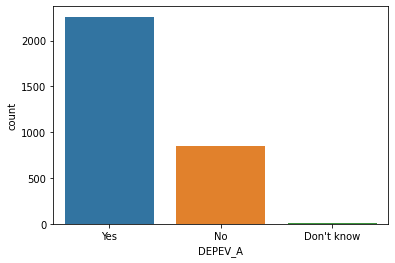

In [10]:
labels = {1:'Yes', 2: 'No', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPEV_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPEV_A', data = depressed_core)

The majority have been diagnosed as depressed although over 500 have not been told by a doctor they have depression.  To reduce the number of columns when one hot encoding, I'm going to replace yes with 1, no with -1, and don't know with 0


In [11]:
labels = {'Yes':1,'No':-1,"Don't know":0}
depressed_core.DEPEV_A.replace(labels, inplace=True)

DEPFREQ_A is the response to the question "How often do you feel depressed?" The values DEPFREQ_A can take are: 1, daily; 2, weekly; 3, monthly; 4, a few times a year; 5 never; 7, refused; 8, not ascertained; 9, don't know.  Earlier I filtered the dataframe to only include values of 1 or 2.  Renaming the labels and creating a countplot... 

<AxesSubplot:xlabel='DEPFREQ_A', ylabel='count'>

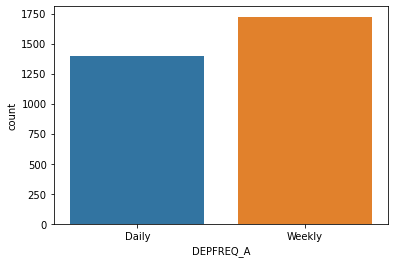

In [12]:
labels = {1:'Daily',2:'Weekly'}
depressed_core.DEPFREQ_A.replace(labels,inplace=True)
sns.countplot(x='DEPFREQ_A', data=depressed_core)

As you can see more feel depression on a weekly basis but it close to even.

DEPMED_A represents respondants to the question, "Do you take prescription medication for depression?"  The values are: 1, yes; 2, no; 7, refused; 8, not ascertained; and 9, don't know.

<AxesSubplot:xlabel='DEPMED_A', ylabel='count'>

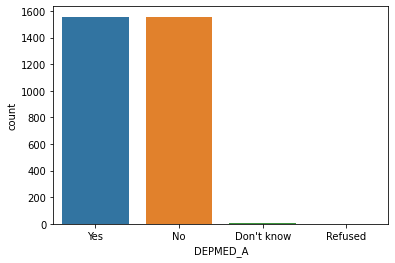

In [13]:
labels = {1:'Yes',2:'No',7:'Refused',8:'Not ascertained',9:"Don't know"}
depressed_core.DEPMED_A.replace(labels,inplace=True)
sns.countplot(x='DEPMED_A',data=depressed_core)

An equal amount of those feeling depression take and do not take medication for depression.  
I am going to combine 'Don't know' and Refused into an 'Other' category

In [14]:
labels = {"Don't know":'Other','Refused':'Other'}
depressed_core.DEPMED_A.replace(labels,inplace=True)

DEPLEVEL_A is the respondants answer to the question, "Thinking about the last time you felt depressed, how depressed did you feel?  Would you say a little, a lot, or somewhere in between?".  Values represented: 1, a little; 2, a lot; 3, somewhere in between a little and a lot; 7, refused; 8, not ascertained; 9, don't know. 

<AxesSubplot:xlabel='DEPLEVEL_A', ylabel='count'>

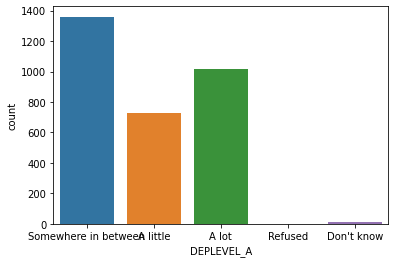

In [15]:
labels = {1: 'A little', 2: 'A lot', 3: 'Somewhere in between', 7: 'Refused', 8: 'Not ascertained', 9: "Don't know"}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)
sns.countplot(x = 'DEPLEVEL_A', data = depressed_core)

The majority feel somewhere in between a little and a lot. 
Again I am going to combine refused and Don't know into an other category

In [16]:
labels = {'Refused':"Other","Don't Know":"Other"}
depressed_core.DEPLEVEL_A.replace(labels, inplace=True)


PHQ81_A holds responses from the question, "Over the last two weeks how often have you been bothered by little interest or pleasure in doing things?" Responses include: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; 9, don't know.

<AxesSubplot:xlabel='PHQ81_A', ylabel='count'>

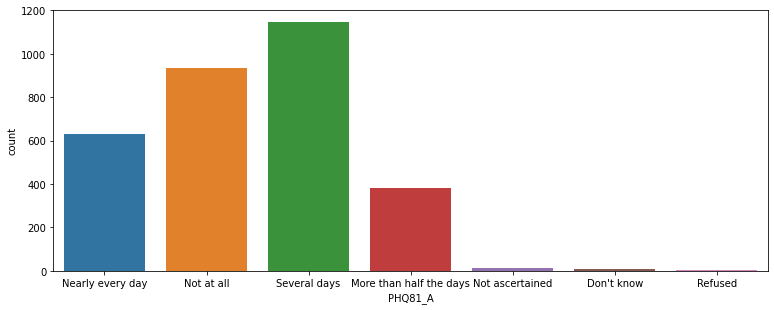

In [17]:
labels = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
depressed_core.PHQ81_A.replace(labels, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ81_A', data=depressed_core)

The majority of those facing depression feels bothered by little interest or pleasure several days. I am going to combine Not ascertained, don't know and refused into an other category 

In [18]:
labels_other = {"Don't know":'Other',"Refused":'Other',"Not ascertained":'Other'}
depressed_core.PHQ81_A.replace(labels_other, inplace=True)

PHQ82_A holds the answer to: in the past two weeks, how often have you been bothered by feeling down, depressed or hopeless?
The data can take on values: 1, not at all; 2, several days; 3, more than half the days; 4, nearly every day; 7, refused; 8, not ascertained; or 9, don't know.

<AxesSubplot:xlabel='PHQ82_A', ylabel='count'>

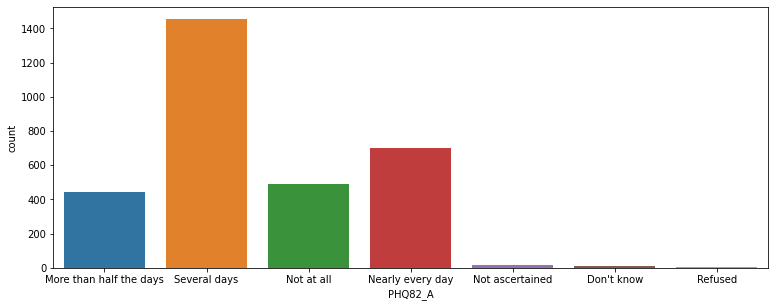

In [19]:
labels_ntostr = {1: 'Not at all', 2: 'Several days', 3: 'More than half the days', 4: 'Nearly every day', 7: 'Refused', 
          8: 'Not ascertained', 9: "Don't know"}
depressed_core.PHQ82_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ82_A', data=depressed_core)


Again most felt down several days.  And again, those will a small amount of values, I am placing in one bucket, 'other'

In [20]:
depressed_core.PHQ82_A.replace(labels_other, inplace=True)

PHQ83_A indicates how often in the past two weeks people have been bothered by trouble falling asleep, trouble staying aslepp, or sleeping too much.

<AxesSubplot:xlabel='PHQ83_A', ylabel='count'>

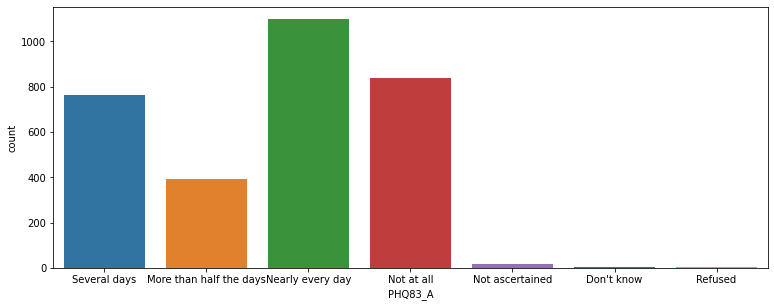

In [21]:
depressed_core.PHQ83_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ83_A', data=depressed_core)

In this case the majority of those with depression have been feeling bothered by trouble with sleep nearly every day

In [22]:
depressed_core.PHQ83_A.replace(labels_other, inplace=True)

PHQ84_A records responses to the question on over the past two weeks how often have you been bothered by feeling tired or having little energy.

<AxesSubplot:xlabel='PHQ84_A', ylabel='count'>

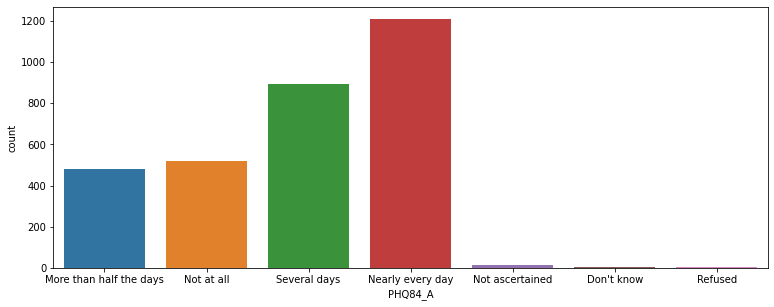

In [23]:
depressed_core.PHQ84_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ84_A', data=depressed_core)


Notice most have trouble with energy levels nearly every day.



In [24]:
depressed_core.PHQ84_A.replace(labels_other, inplace=True)

PHQ85_A reports how many times in the past two weeks have people been bothered by a poor appetite or overeating.

<AxesSubplot:xlabel='PHQ85_A', ylabel='count'>

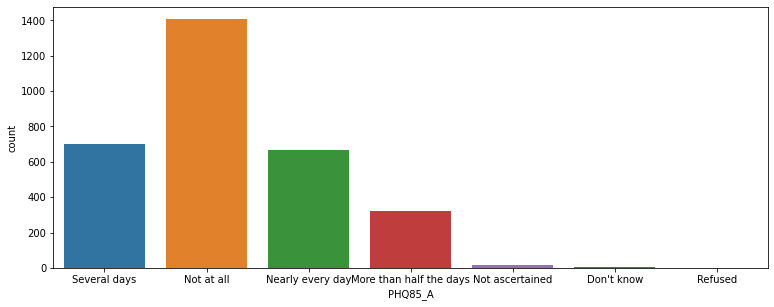

In [25]:
depressed_core.PHQ85_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ85_A', data=depressed_core)

The majority were not at all bothered by over or under eating.



In [26]:
depressed_core.PHQ85_A.replace(labels_other, inplace=True)

PHQ86_A reports how many times over the past two weeks, people have been bothered by feeling bad about themselves.

<AxesSubplot:xlabel='PHQ86_A', ylabel='count'>

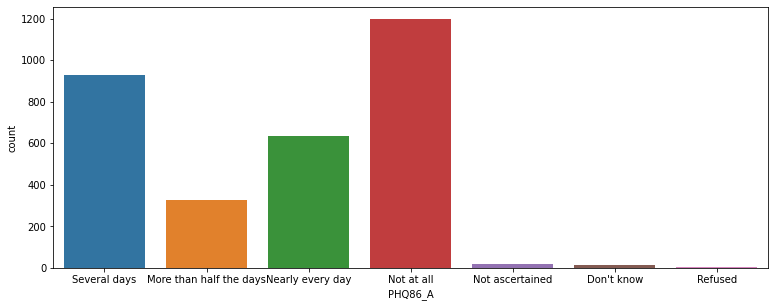

In [27]:
depressed_core.PHQ86_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ86_A', data=depressed_core)

As can be seen there is a split between several days or not at all.



In [28]:
depressed_core.PHQ86_A.replace(labels_other, inplace=True)

PHQ87_A reports how many times over the past few weeks people have been bothered by trouble concentrating

<AxesSubplot:xlabel='PHQ87_A', ylabel='count'>

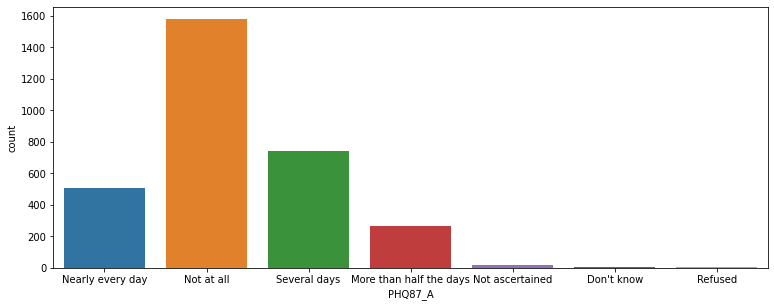

In [29]:
depressed_core.PHQ87_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ87_A', data=depressed_core)

Most were not bothered by trouble concentrating



In [30]:
depressed_core.PHQ87_A.replace(labels_other, inplace=True)

PHQ88_A asks how often in the past few weeks people were bothered by moving or speaking slow or fast.

<AxesSubplot:xlabel='PHQ88_A', ylabel='count'>

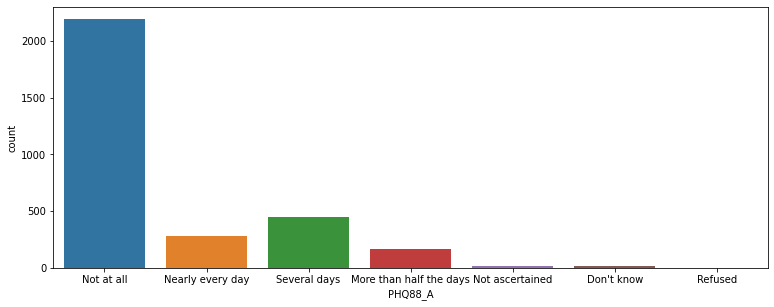

In [31]:
depressed_core.PHQ88_A.replace(labels_ntostr, inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='PHQ88_A', data=depressed_core)

The clear majority is not at all

In [32]:
depressed_core.PHQ88_A.replace(labels_other, inplace=True)

In [33]:
depressed_core.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DEPEV_A     3118 non-null   int64 
 1   DEPFREQ_A   3118 non-null   object
 2   DEPMED_A    3118 non-null   object
 3   DEPLEVEL_A  3118 non-null   object
 4   PHQ81_A     3118 non-null   object
 5   PHQ82_A     3118 non-null   object
 6   PHQ83_A     3118 non-null   object
 7   PHQ84_A     3118 non-null   object
 8   PHQ85_A     3118 non-null   object
 9   PHQ86_A     3118 non-null   object
 10  PHQ87_A     3118 non-null   object
 11  PHQ88_A     3118 non-null   object
dtypes: int64(1), object(11)
memory usage: 381.2+ KB


#  Visualizing the data using PCA and UMAP

In [34]:
df_depressed_core = pd.get_dummies(depressed_core)
df_depressed_core.shape

(3118, 51)

In [35]:
X = df_depressed_core.values

Text(0.5, 1.0, 'UMAP')

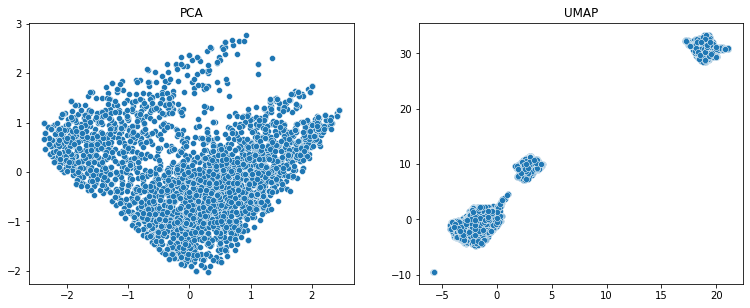

In [36]:
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

It looks like there may be 2 or 3 clusters.  

# Kmeans

<AxesSubplot:>

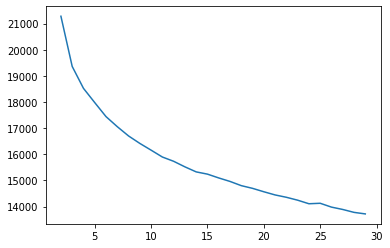

In [37]:
inertia_values = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

Unfortunately there is no apparent elbow.  Maybe around 14 or 24.  I'm going to check silhouette scores for values from 5 to 25

In [38]:
for n in range(5,26):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 5 clusters is 0.09964354440786358
The silhouette score for 6 clusters is 0.09213158915625892
The silhouette score for 7 clusters is 0.08180865170993123
The silhouette score for 8 clusters is 0.0919172384516983
The silhouette score for 9 clusters is 0.08327156562788508
The silhouette score for 10 clusters is 0.08637104021520252
The silhouette score for 11 clusters is 0.07653439658932741
The silhouette score for 12 clusters is 0.06861151243773893
The silhouette score for 13 clusters is 0.0777244268887226
The silhouette score for 14 clusters is 0.06888450746106409
The silhouette score for 15 clusters is 0.06794421510473586
The silhouette score for 16 clusters is 0.06659903088013551
The silhouette score for 17 clusters is 0.06509636845749776
The silhouette score for 18 clusters is 0.07006776859969718
The silhouette score for 19 clusters is 0.06307443175490404
The silhouette score for 20 clusters is 0.06606638129656851
The silhouette score for 21 clusters is 0.06442

All seems low, the silhouette score keeps droping.  K means may not be the best clustering algorithm or more information is needed.  I'm going to see what DBSCAN picks

# DBSCAN

In [39]:
df_depressed_core.shape[1]

51

DBSCAN has two main parameters, eps and min samples.  According to the Analytics Vidhya blog post, min samples should be at least one more than the number of parameters.  Other blogs suggest two times the number of parameters.  I am going to try values in the range of 52 to 130 in incriments of 4.  Next I need to find the best epsilon values for these min samples.  From the same article, the best epsilon is found using the K_neighbors_graph.  The medium article shows how to plot the k_neighbors graph to determine eps. 

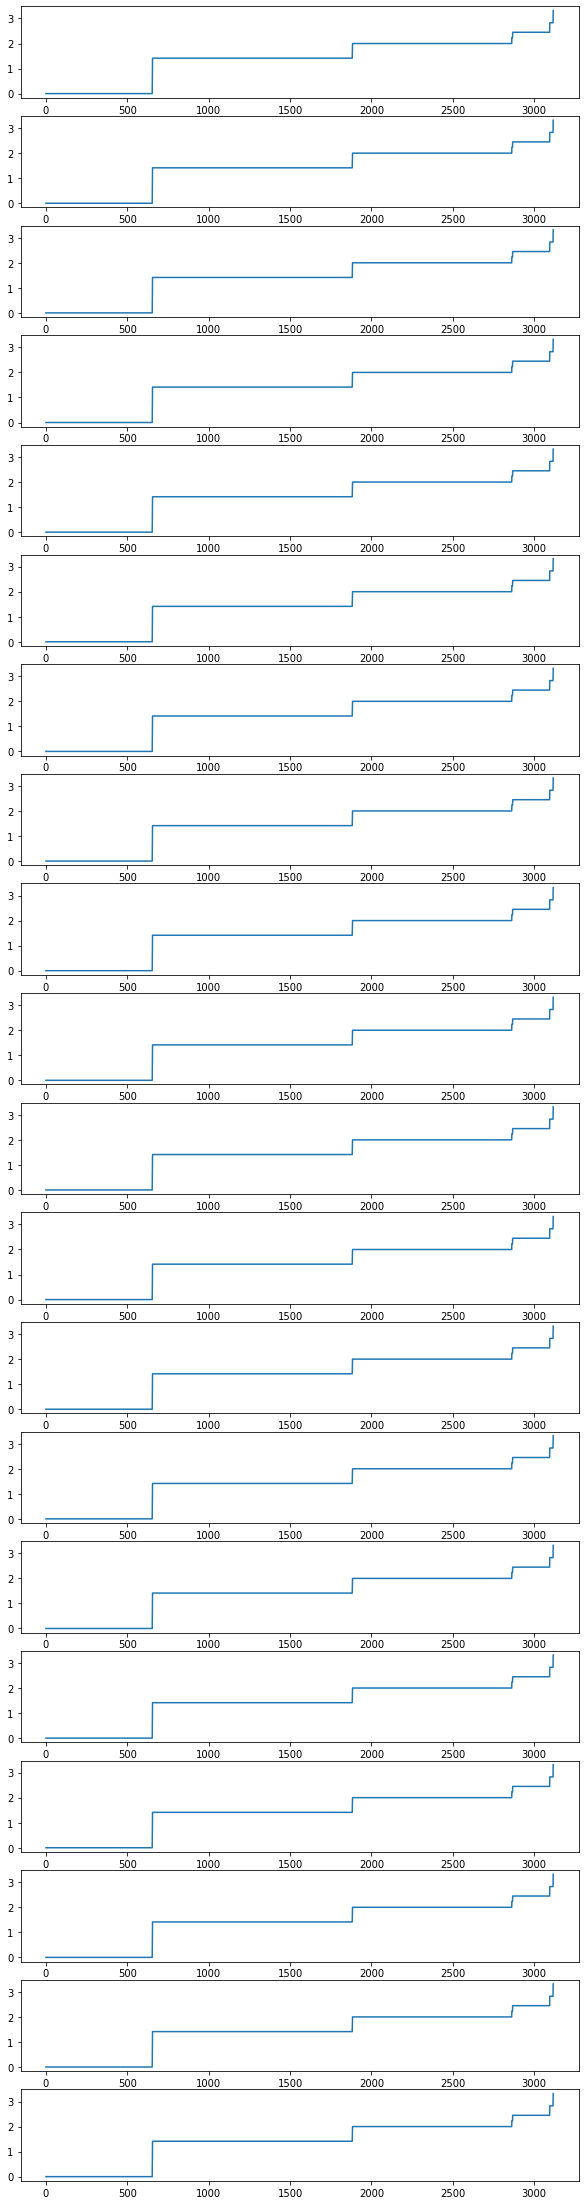

In [40]:
fig, axs = plt.subplots(nrows=20, ncols=1, figsize=(10,40))
i = 0
for k in range(52,130,4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    axs[i].plot(distances)
    i+=1
    
    

For each of these the knee appears between 1 and 2.  Going to try a knee of 1.5 then find which min samples produces the best silhouette score.  Finally adjust eps to find the best eps.

In [41]:
for min_samples in range(52,130,4):
    db = DBSCAN(eps=1.5, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass
    

The silhouette score for min_samples of 52 is 0.6290170445290034
The silhouette score for min_samples of 56 is 0.6565928472138962
The silhouette score for min_samples of 60 is 0.6565928472138962
The silhouette score for min_samples of 64 is 0.6693308258983449
The silhouette score for min_samples of 68 is 0.6853179316452305
The silhouette score for min_samples of 72 is 0.6853179316452305
The silhouette score for min_samples of 76 is 0.6853179316452305


After a value of 68, there is no difference in silhouette score.

Going to now try to find the best eps with min_samples = 68

In [42]:
for eps in np.linspace(1.25, 1.75,20):
    db = DBSCAN(eps=eps, min_samples=68)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for eps {} is {}".format(eps,ss))
    except:
        pass

The silhouette score for eps 1.4342105263157894 is 0.6853179316452305
The silhouette score for eps 1.4605263157894737 is 0.6853179316452305
The silhouette score for eps 1.486842105263158 is 0.6853179316452305
The silhouette score for eps 1.513157894736842 is 0.6853179316452305
The silhouette score for eps 1.5394736842105263 is 0.6853179316452305
The silhouette score for eps 1.5657894736842106 is 0.6853179316452305
The silhouette score for eps 1.5921052631578947 is 0.6853179316452305
The silhouette score for eps 1.618421052631579 is 0.6853179316452305
The silhouette score for eps 1.6447368421052633 is 0.6853179316452305
The silhouette score for eps 1.6710526315789473 is 0.6853179316452305
The silhouette score for eps 1.6973684210526314 is 0.6853179316452305
The silhouette score for eps 1.7236842105263157 is 0.6853179316452305
The silhouette score for eps 1.75 is 0.6853179316452305


None of these made a difference.  Going to keep 1.5 as eps and 68 as min samples

In [43]:
db = DBSCAN(eps = 1.5, min_samples = 68)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 2


In [44]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1], dtype=int64), array([2956,   84,   78], dtype=int64))

In [45]:
print("The silhouette score for DBSCAN is {}".format(silhouette_score(X[preds!=-1],preds[preds!=-1])))

The silhouette score for DBSCAN is 0.6853179316452305


The silhouette score is high for two clusters.  
According to this paper, the amount of noise should be between 1 and 30 percent.  Here the amount of noice is over 90 percent.  Both Kmeans and Dbscan did not produce good clusters.  To try to improve the clusters, I am going to add more information to the data.  
  
Depression effects women more than men.  So first I am adding general demographics.

# Looking at demographics

In [46]:
demographics = ['AGEP_A','SEX_A','MARITAL_A', 'FAMINCTC_A','EDUC_A','EMPWRKLSWK_A','RACEALLP_A','HISP_A']
depressed_demo = df_depressed[demographics].copy()

AGEP_A contains the age of the adult individual.

<AxesSubplot:>

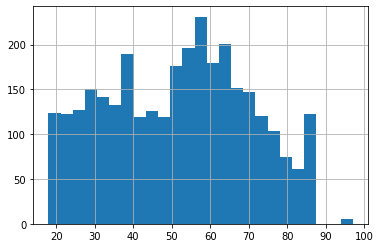

In [47]:
depressed_demo.AGEP_A.hist(bins=25)

From the histogram you can see adults of all ages struggle with depression.  The peaks are right before 40 and between 50 and 65.

SEX_A contains the gender of the adult.

<AxesSubplot:xlabel='SEX_A', ylabel='count'>

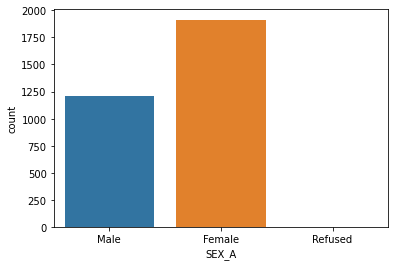

In [48]:
labels = {1:'Male',2:'Female',7:'Refused',8:'Not Ascertained',9:"Don't Know"}
depressed_demo.SEX_A.replace(labels,inplace=True)
sns.countplot(x='SEX_A',data=depressed_demo)

Notice there are more females than males.

MARITAL_A lists the marital status of the adult.

<AxesSubplot:xlabel='MARITAL_A', ylabel='count'>

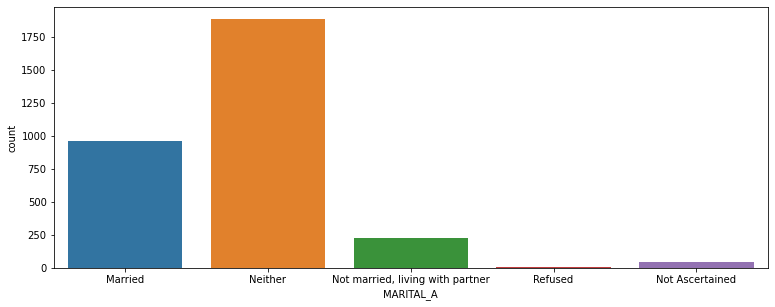

In [49]:
labels = {1:'Married',2:'Not married, living with partner',3:'Neither',7:'Refused',8:'Not Ascertained',9:"Don't Know"}
depressed_demo.MARITAL_A.replace(labels,inplace=True)
plt.figure(figsize=(12.8, 4.8))
sns.countplot(x='MARITAL_A',data=depressed_demo)

Most are not married and not living with a partner.

Going to combine refuesd and not ascertained into an other column.

In [50]:
labels = {'Refused':'Other','Not Ascertained':'Other'}
depressed_demo.MARITAL_A.replace(labels,inplace=True)

FAMINCTC_A has the family income.

<AxesSubplot:>

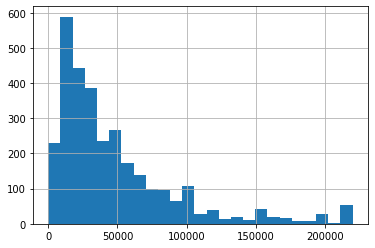

In [51]:
depressed_demo.FAMINCTC_A.hist(bins=25)

Most of those depressed have lower income.

EDUC_A has the education level of the adult.

<AxesSubplot:xlabel='count', ylabel='EDUC_A'>

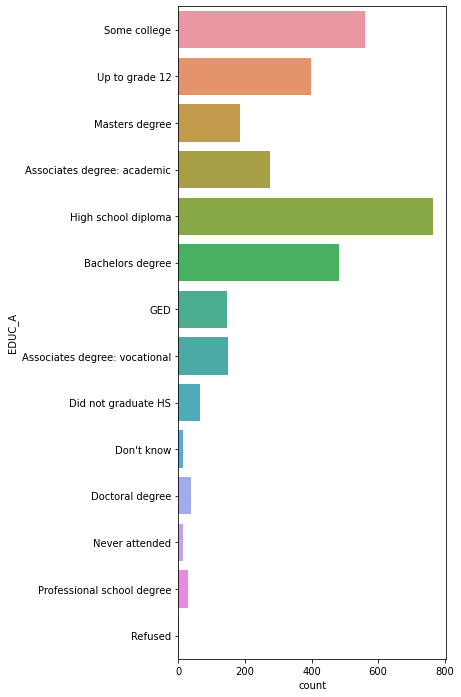

In [52]:
labels = {0:'Never attended',1:'Up to grade 12',2:'Did not graduate HS',3:'GED',4:'High school diploma',5:'Some college',
          6:'Associates degree: vocational',7:'Associates degree: academic',8:'Bachelors degree',9:'Masters degree',
         10:'Professional school degree',11:'Doctoral degree',97:'Refused',98:'Not ascertained',99:"Don't know"}

depressed_demo.EDUC_A.replace(labels,inplace=True)
plt.figure(figsize=(4.8, 12))
sns.countplot(y='EDUC_A',data=depressed_demo)

For those with depression, the most have a high school diploma.  Since there are many woth few counts, I am going to combine some buckets.

In [53]:
labels = {'Refused':'Other','Never attended':'Other',"Don't know":'Other','Masters degree':'Graduate school complete',
         'Professional school degree':'Graduate school complete','Doctoral degree':'Graduate school complete',
         'Did not graduate HS':'Up to grade 12','Associates degree: academic':'Associates degree',
         'Associates degree: vocational':'Associates degree','GED':'High school diploma'}
depressed_demo.EDUC_A.replace(labels,inplace=True)

In [54]:
depressed_demo.EMPWRKLSWK_A.unique()

array([1, 2, 9], dtype=int64)

EMPWRKLSWK_A denotes whether the adult worked last week.  With 1, yes, 2, no, and 9: don't know.

<AxesSubplot:xlabel='EMPWRKLSWK_A', ylabel='count'>

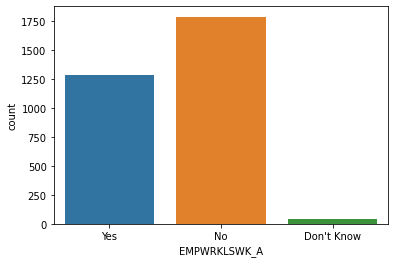

In [55]:
labels = {1:'Yes',2:'No',9:"Don't Know"}
depressed_demo.EMPWRKLSWK_A.replace(labels,inplace=True)
sns.countplot(x='EMPWRKLSWK_A',data=depressed_demo)

For those depressed, most did not work the past week.  I am going to replace yes with 1, no with -1 and don't know with 0

In [56]:
labels = {'Yes':1,'No':-1,"Don't know":0}
depressed_demo.EMPWRKLSWK_A.replace(labels,inplace=True)

RACEALLP_A denotes single and multiple race groups.

In [57]:
depressed_demo.RACEALLP_A.unique()

array([1, 2, 5, 8, 3, 4, 6], dtype=int64)

1: White only
2: Black/African American only
3: Asian only
4: American indian only
5: American indian and any other group
6: Other single and multiple races
8: Not ascertained

<AxesSubplot:xlabel='count', ylabel='RACEALLP_A'>

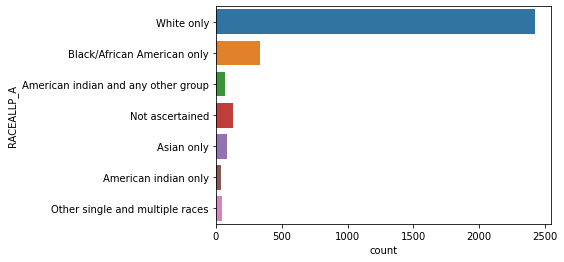

In [58]:
labels = {1: 'White only', 2: 'Black/African American only', 3: 'Asian only', 4: 'American indian only', 
          5: 'American indian and any other group', 6: 'Other single and multiple races', 8: 'Not ascertained'}
depressed_demo.RACEALLP_A.replace(labels, inplace=True)
sns.countplot(y='RACEALLP_A',data=depressed_demo)

For those with depression, the most are white.  However 75% of the respondents were white so nothing can be inferred.  I'm going tp combine the two american indian as well as other races and not ascertained.

In [59]:
labels = {'American indian only': 'American indian', 'American indian and any other group':'American indian', 
          'Other single and multiple races':'Other', 'Not ascertained':'Other'}
depressed_demo.RACEALLP_A.replace(labels, inplace=True)

In [60]:
depressed_demo.RACEALLP_A.unique()

array(['White only', 'Black/African American only', 'American indian',
       'Other', 'Asian only'], dtype=object)

HISP_A asks about hispanic ethnicity

In [61]:
depressed_demo.HISP_A.unique()

array([2, 1], dtype=int64)

1: Yes
2: No

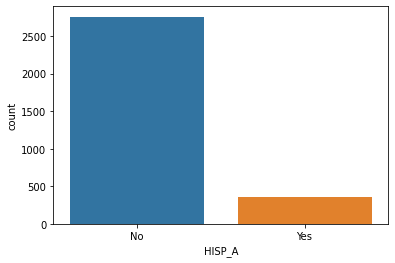

In [62]:
labels = {1:'Yes',2:'No'}
depressed_demo.HISP_A.replace(labels,inplace=True)
sns.countplot(x='HISP_A',data=depressed_demo)
labels={'Yes':1,'No':-1}
depressed_demo.HISP_A.replace(labels,inplace=True)

The majority of those with depression are not Hispanic.

Next, I am going to standardize the two non-ordinal values and use get_dummies to prepare this subset for clustering.  Then I will combine this with df_depressed_core.

In [63]:
depressed_demo.FAMINCTC_A = (depressed_demo.FAMINCTC_A - depressed_demo.FAMINCTC_A.mean())/depressed_demo.FAMINCTC_A.std()
depressed_demo.AGEP_A = (depressed_demo.AGEP_A-depressed_demo.AGEP_A.mean())/depressed_demo.AGEP_A.std()
df_depressed_demo = pd.get_dummies(depressed_demo)

In [64]:
df_depressed_democore = pd.concat([df_depressed_demo,df_depressed_core],axis=1)

In [70]:
df_depressed_democore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3118 entries, 4 to 31990
Data columns (total 76 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   AGEP_A                                      3118 non-null   float64
 1   FAMINCTC_A                                  3118 non-null   float64
 2   HISP_A                                      3118 non-null   int64  
 3   SEX_A_Female                                3118 non-null   uint8  
 4   SEX_A_Male                                  3118 non-null   uint8  
 5   SEX_A_Refused                               3118 non-null   uint8  
 6   MARITAL_A_Married                           3118 non-null   uint8  
 7   MARITAL_A_Neither                           3118 non-null   uint8  
 8   MARITAL_A_Not married, living with partner  3118 non-null   uint8  
 9   MARITAL_A_Other                             3118 non-null   uint8  
 10  EDUC_A_Asso

# Visualizing the dataset

In [68]:
X = df_depressed_democore.values

Text(0.5, 1.0, 'UMAP')

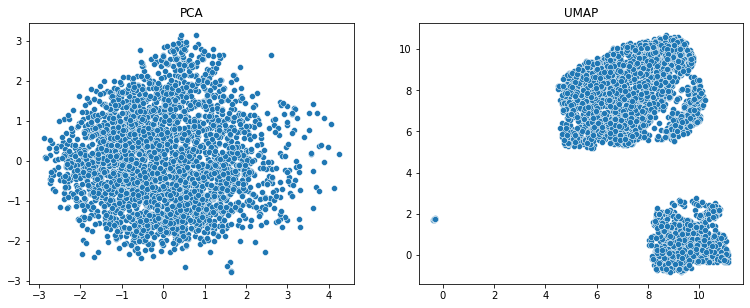

In [69]:
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

PCA appears dense, no visible clustering, while UMAP shows 2 possible clusters.  Although a lot of information is lost as you are going from 76 features to 2.  Trying kmeans...

<AxesSubplot:>

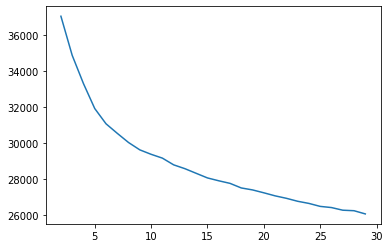

In [71]:
inertia_values = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

Again there is no apparent elbow, maybe around 10 or 18.

In [72]:
for n in range(5,26):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 5 clusters is 0.07389786847122333
The silhouette score for 6 clusters is 0.07288633572044426
The silhouette score for 7 clusters is 0.07132101912771135
The silhouette score for 8 clusters is 0.062448930455488924
The silhouette score for 9 clusters is 0.060159334758607096
The silhouette score for 10 clusters is 0.06078721232036974
The silhouette score for 11 clusters is 0.05986962253675873
The silhouette score for 12 clusters is 0.05052798431856599
The silhouette score for 13 clusters is 0.05527758077003333
The silhouette score for 14 clusters is 0.048777749003922434
The silhouette score for 15 clusters is 0.05093491334529806
The silhouette score for 16 clusters is 0.050684618666270775
The silhouette score for 17 clusters is 0.04863915950722439
The silhouette score for 18 clusters is 0.0480714517265883
The silhouette score for 19 clusters is 0.04427663887659013
The silhouette score for 20 clusters is 0.04656838396729724
The silhouette score for 21 clusters is 0.

Again the silhouette scores are closed to 0, meaning clusters are combining.

Trying DBSCAN...

In [73]:
df_depressed_democore.shape[1]

76

With 76 features, the min_samples shoud be at least 77.  Going to try to find the best eps using values from 77 to 154 in increments of 4.

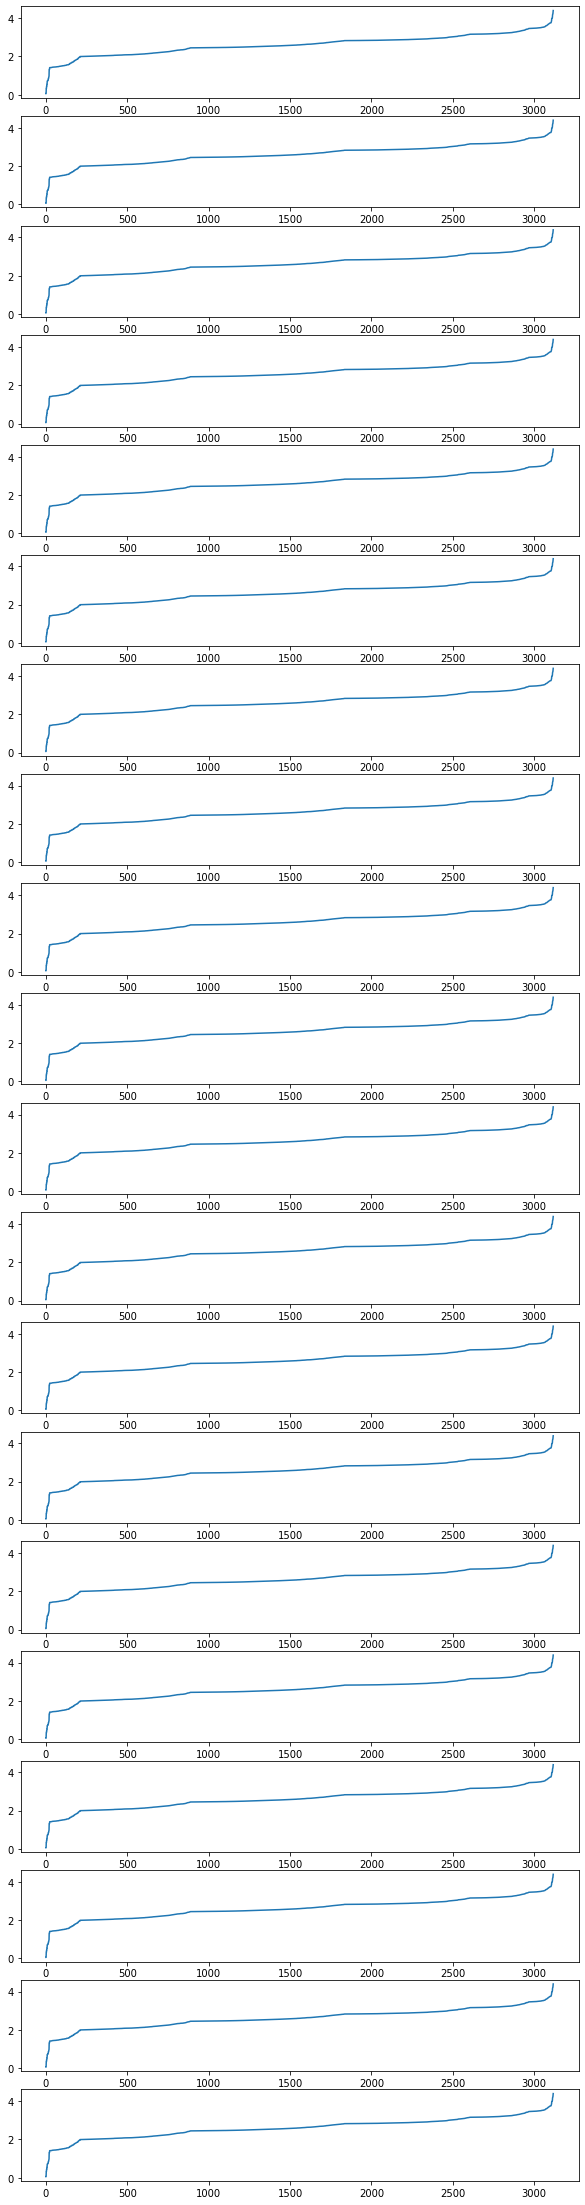

In [74]:
fig, axs = plt.subplots(nrows=20, ncols=1, figsize=(10,40))
i = 0
for k in range(77,154,4):
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(X)
    distances, _ = neighbors_fit.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    axs[i].plot(distances)
    i+=1

Here epsilon looks at around 1.75 or 2.

In [76]:
for min_samples in range(77,154,4):
    db = DBSCAN(eps=1.75, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

In [80]:
db = DBSCAN(eps=1.75, min_samples = 77)
preds = db.fit_predict(X)
preds.max()

-1

Unfortunately this predicts everything as an outlier.  I'm going to increase eps to 3 and reduce min_samples to 50.

In [84]:
db = DBSCAN(eps=3, min_samples = 50)
preds = db.fit_predict(X)
preds.max()

2

In [87]:
for min_samples in range(10,51,5):
    db = DBSCAN(eps=3, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

The silhouette score for min_samples of 45 is 0.1781518570677813
The silhouette score for min_samples of 50 is 0.17611335102241485


Increasing eps and reducing min_samples produced more than 1 cluser, but the silhouette score is low.  I want to try this with just the depressed_demo and not including the depressed_core

Text(0.5, 1.0, 'UMAP')

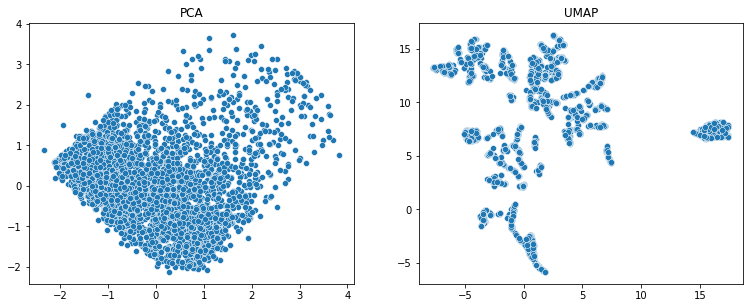

In [88]:
X = df_depressed_demo.values
pca=PCA(n_components=2)
X_2d_pca = pca.fit_transform(X)
umap = UMAP(n_components=2)
X_2d_umap = umap.fit_transform(X)
fig, axs = plt.subplots(1,2,figsize=(12.8,4.8))
sns.scatterplot(x=X_2d_pca[:,0],y=X_2d_pca[:,1], ax=axs[0])
axs[0].set_title('PCA')
sns.scatterplot(x=X_2d_umap[:,0],y=X_2d_umap[:,1], ax=axs[1])
axs[1].set_title('UMAP')

UMAP shows some clustering.

<AxesSubplot:>

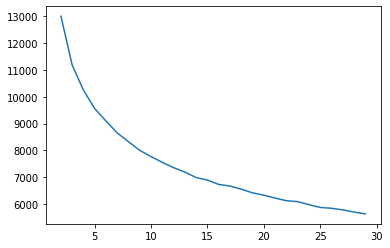

In [89]:
inertia_values = []
for n in range(2,30):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X)
    inertia_values.append((n,kmeans.inertia_))
results = list(zip(*inertia_values))

sns.lineplot(x=results[0],y=results[1])

There is no pronounced elbow but may be an elbow around 15 or 24

In [90]:
for n in range(5,26):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    print("The silhouette score for {} clusters is {}".format(n,silhouette_score(X,preds)))

The silhouette score for 5 clusters is 0.15800753758823377
The silhouette score for 6 clusters is 0.14822560322081305
The silhouette score for 7 clusters is 0.14810513403925718
The silhouette score for 8 clusters is 0.14064797421160835
The silhouette score for 9 clusters is 0.14448893654088452
The silhouette score for 10 clusters is 0.15584447343838684
The silhouette score for 11 clusters is 0.14210381044995554
The silhouette score for 12 clusters is 0.1569583372000604
The silhouette score for 13 clusters is 0.14268103734838553
The silhouette score for 14 clusters is 0.1397315147003101
The silhouette score for 15 clusters is 0.1427420342556854
The silhouette score for 16 clusters is 0.145394629517417
The silhouette score for 17 clusters is 0.1489342421995611
The silhouette score for 18 clusters is 0.14822596188249787
The silhouette score for 19 clusters is 0.14570868800979098
The silhouette score for 20 clusters is 0.14512364092914812
The silhouette score for 21 clusters is 0.143759615

The best silhouette score is for 26, now going to try DBSCAN

In [91]:
df_depressed_demo.shape[1]

25

With 25 features there should be at least min_clusters 26.  Going to look for eps with n_neighors = 30

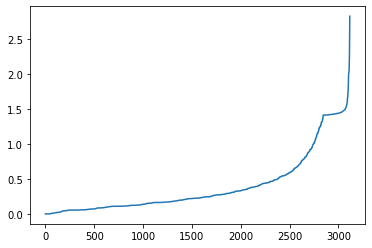

In [93]:
neighbors = NearestNeighbors(n_neighbors=30)
neighbors_fit = neighbors.fit(X)
distances, _ = neighbors_fit.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

There is a definite knee around 1.5 and 0.5

In [94]:
for min_samples in range(26,61,2):
    db = DBSCAN(eps=1.5, min_samples = min_samples)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for min_samples of {} is {}".format(min_samples, ss))
    except:
        pass

The silhouette score for min_samples of 26 is 0.17688552732412643
The silhouette score for min_samples of 28 is 0.1773179881034875
The silhouette score for min_samples of 30 is 0.17128741368247377
The silhouette score for min_samples of 32 is 0.16286303223167062
The silhouette score for min_samples of 34 is 0.16365074193417678


The best silhouette score is at 28 min samples

In [98]:
for eps in np.linspace(0.5, 1.5,51):
    db = DBSCAN(eps=eps, min_samples=28)
    preds = db.fit_predict(X)
    try:
        ss = silhouette_score(X[preds!=-1],preds[preds!=-1])
        print("The silhouette score for eps {} is {}".format(eps,ss))
    except:
        pass

The silhouette score for eps 0.5 is 0.5718693657732984
The silhouette score for eps 0.52 is 0.5631014020537827
The silhouette score for eps 0.54 is 0.5608967535182265
The silhouette score for eps 0.56 is 0.5286556588510318
The silhouette score for eps 0.58 is 0.5225218940244124
The silhouette score for eps 0.6 is 0.5124494529603163
The silhouette score for eps 0.62 is 0.5009410713944865
The silhouette score for eps 0.64 is 0.4911072443991366
The silhouette score for eps 0.66 is 0.4872928733282158
The silhouette score for eps 0.6799999999999999 is 0.49999957806002576
The silhouette score for eps 0.7 is 0.4924724472436707
The silhouette score for eps 0.72 is 0.4743205153381731
The silhouette score for eps 0.74 is 0.47066810046710283
The silhouette score for eps 0.76 is 0.468563648306928
The silhouette score for eps 0.78 is 0.4616952747979245
The silhouette score for eps 0.8 is 0.44374197449121616
The silhouette score for eps 0.8200000000000001 is 0.43689617591252494
The silhouette score 

The best eps is 0.5

In [99]:
db = DBSCAN(eps = 0.5, min_samples = 28)
preds = db.fit_predict(X)
print('The number of clusters selected by DBSCAN is {}'.format(preds.max()+1))

The number of clusters selected by DBSCAN is 5


In [100]:
np.unique(preds, return_counts=True)

(array([-1,  0,  1,  2,  3,  4], dtype=int64),
 array([2812,  140,   45,   39,   44,   38], dtype=int64))

Still more than 90% noise, however there is less noise than using the depressed_core dataframe.